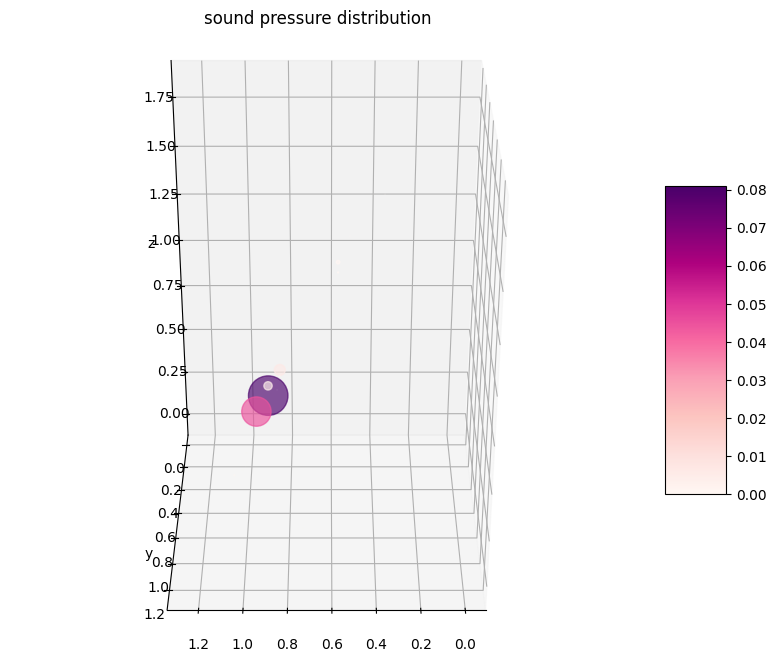

In [40]:
import numpy as np
import acoular as ac
# import pyfar as pf
import matplotlib.pyplot as plt

resFileName = "out/beamforming_results_25_02_16/2025-01-28_14-57-26_453699/result_2025-01-28_14-57-26_453699"
dotsize = 4
resolution = 0.05

# read Data
result = np.load(resFileName + ".npy")
# start, stop, framerate, frames, frequency_bands, bandwith, resolution, name = pf.io.read(resFileName+".far")
# result_Lp = ac.L_p(result)[4,85]        # convert results in sound pressure Level
# map = result_Lp

map = result[2,61] # frequenzband 2, frame 41

a = map.shape[0]
fig = plt.figure(figsize = [10,8])
ax = fig.add_subplot(projection='3d')
ax.view_init(elev=30, 
             azim=90, 
             roll=0)
ax.set_proj_type('persp', focal_length=0.547)
x_m, y_m, z_m = np.meshgrid(np.linspace(0,map.shape[0]*resolution,map.shape[0]),
                            np.linspace(0,map.shape[1]*resolution,map.shape[1]), 
                            np.linspace(0,map.shape[2]*resolution,map.shape[2]))
sc = ax.scatter(x_m, y_m, z_m, c = map, s = map*10**dotsize, cmap='RdPu')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.set_title('sound pressure distribution')
ax.set_aspect('equal')
plt.colorbar(sc, ax=ax, shrink=0.5, aspect=5)
plt.show()

In [13]:
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from pytransform3d.plot_utils import make_3d_axis
from pytransform3d.rotations import active_matrix_from_intrinsic_euler_xyz
from pytransform3d.transformations import transform_from, plot_transform
from pytransform3d.camera import make_world_grid, world2image, plot_camera, cam2sensor, sensor2img
from pytransform3d.transformations import transform_from, plot_transform

micgeofile = Path().resolve() / ("in" + "/array_position_data/bassoon_cage_64_optimized.xml")
m = ac.MicGeom(from_file=micgeofile).mpos.T
m = np.vstack((m.T, np.linspace(0,1,len(m))*0.002)).T
# np.ones(len(m))*0.002


# flatten the pressure map and create a 2D array with the coordinates
x_m, y_m, z_m = np.meshgrid(np.linspace(0,map.shape[0]*resolution,map.shape[0]),
                            np.linspace(0,map.shape[1]*resolution,map.shape[1]),
                            np.linspace(0,map.shape[2]*resolution,map.shape[2]))

x_flat = x_m.ravel()
y_flat = y_m.ravel()
z_flat = z_m.ravel()
pressure_flat = map.ravel()

# Stack the flattened coordinates into a 2D array
coordinates_2d = np.vstack((x_flat, y_flat, z_flat)).T
coordinates_2d_stacked = np.hstack((coordinates_2d, np.array([np.zeros(len(coordinates_2d))]).T))


# Initialize the camera parameters
camera_1_pos = np.array([1.3236992,  0.04429161, 0.52348324])
camera_2_pos = np.array([1.16191888, 0.76769209, 1.82988376])
focal_length = 0.0015

sensor_size = np.array([0.00617, 0.00455])
image_size = np.array([1920, 1080])
intrinsic_camera_matrix = np.array([
    [focal_length,  0,              sensor_size[0] / 2],
    [0,             focal_length,   sensor_size[1] / 2],
    [0,             0,              1]
])

# Define the camera transformation matrices
cam1 = transform_from(active_matrix_from_intrinsic_euler_xyz([-np.pi/2+0.7, 0.4, np.pi]),camera_1_pos)
cam2 = transform_from(active_matrix_from_intrinsic_euler_xyz([0,0.5, np.pi]),camera_2_pos)

# # cam_grid = make_world_grid(n_points_per_line=11) - np.array([0, 0, -2, -5])
# cam_grid = coordinates_2d
# img_grid_3d = cam_grid * focal_length
# sensor_grid = cam2sensor(cam_grid, focal_length)
# img_grid = sensor2img(sensor_grid, sensor_size, image_size)

# project the 3D points onto the image plane
pressure_dist1 = world2image(coordinates_2d_stacked, cam1, sensor_size.T, image_size.T, focal_length, kappa = 0)
mic_pos1 = world2image(m, cam1, sensor_size.T, image_size.T, focal_length, kappa = 0)
pressure_dist2 = world2image(coordinates_2d_stacked, cam2, sensor_size, image_size, focal_length, kappa = 0)
mic_pos2 = world2image(m, cam2, sensor_size, image_size, focal_length, kappa = 0)


# plot the 3D scene
fig = plt.figure(figsize = [16,14])
ax = plt.subplot(131, projection="3d")
ax.view_init(elev=15, 
             azim=70, 
             roll=0)
# ax.set_proj_type('persp', focal_length=0.547)

# plot sond pressure distribution
ax.scatter(x_m,                 y_m,                z_m,                c = map,            s = map*10**dotsize, alpha=0.2)
# ax.scatter(img_grid_3d[:, 0],   img_grid_3d[:, 1],  img_grid_3d[:, 2],  c = map,            s = map*focal_length*10**dotsize)
ax.scatter(m[:,0],m[:,1],m[:,2], c = m[:,3],s = 10)

# plot and transform cam position 1
plot_camera(ax, intrinsic_camera_matrix, cam1,
            sensor_size=sensor_size.T, virtual_image_distance=0.2)
# plot_transform(ax = ax, A2B = cam1, s = 0.3, name = "Camera 1")

# plot and transform cam position 2
plot_camera(ax, intrinsic_camera_matrix, cam2,
            sensor_size=sensor_size, virtual_image_distance=0.2)
# plot_transform(ax = ax, A2B = cam2, s = 0.3, name = "Camera 2")

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.set_xlim(np.max(x_m)+0.1,-0.1)
ax.set_ylim(-0.1,0.1+np.max(y_m))
ax.set_title('sound pressure distribution')
ax.set_aspect('equal')



# plot the 2D image planes
ax2 = plt.subplot(132, aspect="equal")
ax2.set_title("View from Camera 1")
ax2.scatter(pressure_dist1[:, 0], pressure_dist1[:, 1], c = pressure_flat, s = pressure_flat*10**dotsize)
ax2.scatter(mic_pos1[:, 0], mic_pos1[:, 1], c = m[:,3], s = 10, alpha=0.8)
ax2.set_xlabel('x')
ax2.set_ylabel('y')
ax2.set_aspect('equal')
ax2.set_xlim(0,image_size[1])
ax2.set_ylim(0,image_size[0])


ax3 = plt.subplot(133, aspect="equal")
ax3.set_title("View from Camera 2")
ax3.scatter(pressure_dist2[:, 0], pressure_dist2[:, 1], c = pressure_flat, s = pressure_flat*10**dotsize)
ax3.scatter(mic_pos2[:, 0], mic_pos2[:, 1], c = m[:,3], s = 10, alpha=0.8,)
ax3.set_xlabel('x')
ax3.set_ylabel('y')
ax3.set_aspect('equal')
ax3.set_xlim(image_size[0],0)
ax3.set_ylim(0,image_size[1])



plt.show()

ModuleNotFoundError: No module named 'pytransform3d'